<a href="https://colab.research.google.com/github/VSTVR/-/blob/master/LeAlexCompare_colab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
MedMNIST v2.0.2 @ https://github.com/MedMNIST/MedMNIST/

Dataset BloodMNIST (bloodmnist)
    Number of datapoints: 11959
    Root location: ./dataset/medmnist/bloodmnist
    Split: train
    Task: multi-class
    Number of channels: 3
    Meaning of labels: {'0': 'basophil', '1': 'eosinophil', '2': 'erythroblast', '3': 'ig', '4': 'lymphocyte', '5': 'monocyte', '6': 'neutrophil', '7': 'platelet'}
    Number of samples: {'train': 11959, 'val': 1712, 'test': 3421}
    Description: The BloodMNIST is based on a dataset of individual normal cells, captured from individuals without infection, hematologic or oncologic disease and free of any pharmacologic treatment at the moment of blood collection. It contains a total of 17,092 images and is organized into 8 classes. We split the source dataset with a ratio of 7:1:2 into training, validation and test set. The source

100%|██████████| 94/94 [00:04<00:00, 23.33it/s]


==> Evaluating ...
LeNet-5: train  acc: 0.967  auc:0.791
LeNet-5: test  acc: 0.964  auc:0.786


100%|██████████| 94/94 [00:05<00:00, 17.74it/s]


==> Evaluating ...
AlexNet: train  acc: 0.985  auc:0.873
AlexNet: test  acc: 0.982  auc:0.856


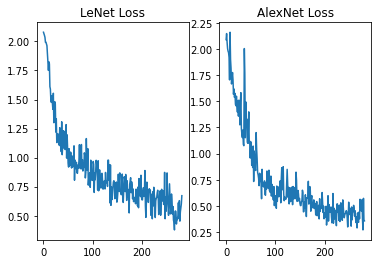

In [ ]:
import os
import torch as tch
import torch.nn as tch_nn
import torch.utils.data as tch_data
from torch.autograd import Variable as tch_var
import torchvision as tch_vision
import matplotlib.pyplot as matplt

from tqdm import tqdm
import numpy as np

# 下载并导入外部库
!pip install medmnist
import medmnist
from medmnist import INFO, Evaluator

# 调用google drive的.py文件，需要获得授权
import sys
from google.colab import drive
drive.mount('/content/drive')
sys.path.append('/content/drive/My Drive/DeepLearning')

from ModelParms import LeNet_5,AlexNet



# System Ctrl
os.environ['KMP_DUPLICATE_LIB_OK'] = 'True'
device = tch.device("cuda" if tch.cuda.is_available() else "cpu")  # CPU / GPU

# Hyper Parameters
EPOCH = 3               # training times
BATCH_SIZE = 128         # 1 batch number
LR = 1e-3                # learning rate


# Download Ctrl
data_flag = 'bloodmnist'
info = INFO[data_flag]  # get dataset info from medmnist
task = info['task']
n_channels = info['n_channels']
n_classes = len(info['label'])
DataClass = getattr(medmnist, info['python_class'])

DOWNLOAD_MNIST = False
print(f"MedMNIST v{medmnist.__version__} @ {medmnist.HOMEPAGE}")


# preprocessing
data_transform = tch_vision.transforms.Compose([
    tch_vision.transforms.ToTensor(),
    tch_vision.transforms.Normalize(mean=[.5], std=[.5])
])

# Download Data
datalocation = './dataset/medmnist/'+data_flag
if not(os.path.exists(datalocation)) or not os.listdir(datalocation):
    os.makedirs(datalocation)
    DOWNLOAD_MNIST = True

train_dataset = DataClass(
    root=datalocation, split='train', transform=data_transform, download=DOWNLOAD_MNIST)
test_dataset = DataClass(
    root=datalocation, split='test', transform=data_transform, download=DOWNLOAD_MNIST)
pil_dataset = DataClass(
    root=datalocation, split='train', download=DOWNLOAD_MNIST)

# Load Data
train_loader = tch_data.DataLoader(
    dataset=train_dataset, batch_size=BATCH_SIZE, shuffle=True)
train_loader_at_eval = tch_data.DataLoader(
    dataset=train_dataset, batch_size=2*BATCH_SIZE, shuffle=False)
test_loader = tch_data.DataLoader(
    dataset=test_dataset, batch_size=2*BATCH_SIZE, shuffle=False)


print("========================================================== \n")
print(train_dataset)
print("-------------- \n")
print(test_dataset)
print("-------------- \n")
print('Input Channels: {0} ; Class: {1} \n'.format(n_channels, n_classes))
print("========================================================== \n")

train_dataset.montage(length=10)






#LeNet-5=============================================================================================  
    
# Model Settings
LeNet5Model = LeNet_5(3, 8).to(device)
# loss function and optimizer
if task == "multi-label, binary-class":
    loss_func_Le = tch_nn.BCEWithLogitsLoss()
else:
    loss_func_Le = tch_nn.CrossEntropyLoss()

#optimizer_Le = tch.optim.SGD(LeNet5Model.parameters(), lr=LR, momentum=0.9)
optimizer_Le = tch.optim.Adam(LeNet5Model.parameters(), lr=LR)

# Train _Le
train_loss_Le = []
for epoch in range(EPOCH):

    #TestModel.train()
    LeNet5Model.train() ###
    for step, (img, label) in enumerate(tqdm(train_loader)):
        img = img.to(device)
        label = label.to(device)
        
        optimizer_Le.zero_grad()
        outputs = LeNet5Model(img) ###

        if task == 'multi-label, binary-class':
            label = label.to(tch.float32)
            loss = loss_func_Le(outputs, label)
        else:
            label = label.squeeze().long()
            loss = loss_func_Le(outputs, label)
        
        train_loss_Le.append(loss.item())
        
        loss.backward()
        optimizer_Le.step()

matplt.subplot(121)
matplt.title('LeNet Loss')
matplt.plot(train_loss_Le)


# Test _Le
def test_Le(split):
    LeNet5Model.eval()
    y_true = tch.tensor([]).to(device)
    y_score = tch.tensor([]).to(device)
    
    data_loader = train_loader_at_eval if split == 'train' else test_loader

    with tch.no_grad():
        for inputs, targets in data_loader:
            
            inputs = inputs.to(device)
            targets = targets.to(device)
            
            outputs = LeNet5Model(inputs)

            if task == 'multi-label, binary-class':
                targets = targets.to(tch.float32)
                outputs = outputs.softmax(dim=-1)
            else:
                targets = targets.squeeze().long()
                outputs = outputs.softmax(dim=-1)
                targets = targets.float().resize_(len(targets), 1)

            y_true = tch.cat((y_true, targets), 0)
            y_score = tch.cat((y_score, outputs), 0)

        y_true = y_true.cpu().numpy()
        y_score = y_score.detach().cpu().numpy()
        
        evaluator = Evaluator(data_flag, split,'./dataset/medmnist/bloodmnist')
        metrics = evaluator.evaluate(y_score)
    
        print('LeNet-5: %s  acc: %.3f  auc:%.3f' % (split, *metrics))

        
print('==> Evaluating ...')
test_Le('train')
test_Le('test')



#AlexNet=======================================================================

# Model Settings
AlexModel = AlexNet(3, 8).to(device)
# loss function and optimizer
if task == "multi-label, binary-class":
    loss_func_Alex = tch_nn.BCEWithLogitsLoss()
else:
    loss_func_Alex = tch_nn.CrossEntropyLoss()

#optimizer = tch.optim.SGD(AlexModel.parameters(), lr=LR, momentum=0.9)
optimizer_Alex = tch.optim.Adam(AlexModel.parameters(), lr=LR)


# Train _Alex
train_loss_Alex = []
for epoch in range(EPOCH):

    AlexModel.train()
    for step, (img, label) in enumerate(tqdm(train_loader)):
        img = img.to(device)
        label = label.to(device)
        
        optimizer_Alex.zero_grad()
        outputs = AlexModel(img) ###

        if task == 'multi-label, binary-class':
            label = label.to(tch.float32)
            loss = loss_func_Le(outputs, label)
        else:
            label = label.squeeze().long()
            loss = loss_func_Le(outputs, label)
        
        train_loss_Alex.append(loss.item())
        
        loss.backward()
        optimizer_Alex.step()

matplt.subplot(122)
matplt.title('AlexNet Loss')
matplt.plot(train_loss_Alex)



# Test _Alex
def test_Alex(split):
    AlexModel.eval()
    y_true = tch.tensor([]).to(device)
    y_score = tch.tensor([]).to(device)
    
    data_loader = train_loader_at_eval if split == 'train' else test_loader

    with tch.no_grad():
        for inputs, targets in data_loader:
            
            inputs = inputs.to(device)
            targets = targets.to(device)
            
            outputs = AlexModel(inputs)

            if task == 'multi-label, binary-class':
                targets = targets.to(tch.float32)
                outputs = outputs.softmax(dim=-1)
            else:
                targets = targets.squeeze().long()
                outputs = outputs.softmax(dim=-1)
                targets = targets.float().resize_(len(targets), 1)

            y_true = tch.cat((y_true, targets), 0)
            y_score = tch.cat((y_score, outputs), 0)

        y_true = y_true.cpu().numpy()
        y_score = y_score.detach().cpu().numpy()
        
        evaluator = Evaluator(data_flag, split,'./dataset/medmnist/bloodmnist')
        metrics = evaluator.evaluate(y_score)
    
        print('AlexNet: %s  acc: %.3f  auc:%.3f' % (split, *metrics))

        
print('==> Evaluating ...')
test_Alex('train')
test_Alex('test')